# EDA - 결측치/이상치 탐지 및 처리(심화)

## 데이터 생성

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display


# 온라인 소매 데이터 생성 (컬럼명 소문자 버전)
np.random.seed(42)
n_customers = 1000

def create_realistic_ecommerce_data(n=1000):
    """실제와 유사한 전자상거래 데이터 생성 (소문자 컬럼명)"""
    
    data = {}
    
    # 고객 기본 정보
    data['customer_id'] = range(1, n+1)
    data['age'] = np.random.normal(35, 12, n).clip(18, 80).astype(int)
    data['gender'] = np.random.choice(['M', 'F'], n, p=[0.45, 0.55])
    data['city'] = np.random.choice(['Seoul', 'Busan', 'Daegu', 'Incheon', 'Gwangju'], 
                                   n, p=[0.4, 0.2, 0.15, 0.15, 0.1])
    
    # 구매 행동 데이터
    data['total_purchases'] = np.random.poisson(8, n) + 1
    data['avg_order_value'] = np.random.lognormal(4.5, 0.8, n).round(2)
    data['days_since_last_purchase'] = np.random.exponential(30, n).astype(int)
    
    # 만족도 및 충성도
    data['satisfaction_score'] = np.random.normal(3.8, 1.2, n).clip(1, 5).round(1)
    data['loyalty_points'] = (data['total_purchases'] * data['avg_order_value'] * 0.1 + 
                             np.random.normal(0, 100, n)).clip(0, None).round(0)
    
    # 카테고리별 구매 금액
    categories = ['electronics', 'clothing', 'books', 'home', 'sports']
    for cat in categories:
        # 일부 고객은 특정 카테고리에서 구매하지 않음
        values = np.random.lognormal(3, 1, n)
        # 30% 확률로 해당 카테고리 구매 안 함 (0으로 설정)
        mask = np.random.random(n) < 0.3
        values[mask] = 0
        data[f'{cat}_spending'] = values.round(2)
    
    df = pd.DataFrame(data)
    
    # 의도적 결측값 생성 (실제 상황 모방)
    
    # 1. MCAR(Missing Completely at Random): 완전 무작위 결측 (시스템 오류)
    missing_indices = np.random.choice(df.index, size=int(0.05 * len(df)), replace=False)
    df.loc[missing_indices, 'satisfaction_score'] = np.nan
    
    # 2. MAR(Missing at Random): 조건부 결측 (나이가 높을수록 만족도 응답 거부율 증가)
    elderly_mask = df['age'] > 50
    elderly_missing = np.random.random(elderly_mask.sum()) < 0.15  
    elderly_indices = df[elderly_mask].index[elderly_missing]
    df.loc[elderly_indices, 'satisfaction_score'] = np.nan
    
    # 3. MNAR(Missing Not at Random): 비무작위 결측 - 결측 자체가 의미 (높은 소득자들이 개인정보 비공개)
    high_spenders = df['avg_order_value'] > df['avg_order_value'].quantile(0.8)
    high_spender_missing = np.random.random(high_spenders.sum()) < 0.25
    high_spender_indices = df[high_spenders].index[high_spender_missing]
    df.loc[high_spender_indices, 'age'] = np.nan
    
    # 도시 정보 일부 결측 (배송지 미입력)
    city_missing = np.random.choice(df.index, size=int(0.08 * len(df)), replace=False)
    df.loc[city_missing, 'city'] = np.nan
    
    # 의도적 이상값 생성
    
    # 1. 데이터 입력 오류 (나이 999살)
    error_indices = np.random.choice(df.index, size=3, replace=False)
    df.loc[error_indices, 'age'] = 999
    
    # 2. 비즈니스 이상값 (VIP 고객의 극도로 높은 구매액) Extreme but Valid Outliers
    vip_indices = np.random.choice(df.index, size=5, replace=False)
    df.loc[vip_indices, 'avg_order_value'] *= 20
    df.loc[vip_indices, 'loyalty_points'] *= 10
    
    # 3. 시스템 버그로 인한 음수값
    bug_indices = np.random.choice(df.index, size=2, replace=False) 
    df.loc[bug_indices, 'days_since_last_purchase'] = -1
    
    return df

# 데이터 생성
ecommerce = create_realistic_ecommerce_data(1000)

print("=== 온라인 소매 데이터 개요 ===")
print(f"데이터 크기: {ecommerce.shape}")
print("\n데이터 샘플:")
display(ecommerce.head(10))

print(f"\n기본 정보:")
print(ecommerce.info())

=== 온라인 소매 데이터 개요 ===
데이터 크기: (1000, 14)

데이터 샘플:


,customer_id,age,gender,city,total_purchases,avg_order_value,days_since_last_purchase,satisfaction_score,loyalty_points,electronics_spending,clothing_spending,books_spending,home_spending,sports_spending
0,1,40.0,M,Seoul,9,80.62,8,3.8,86.0,18.44,0.00,10.65,0.00,184.52
1,2,33.0,M,Seoul,9,27.69,4,2.0,0.0,46.54,0.00,210.79,17.13,20.43
2,3,42.0,F,Seoul,5,71.05,58,2.5,0.0,0.00,4.54,0.00,9.48,0.00
3,4,53.0,F,Seoul,11,158.62,24,1.8,318.0,26.55,25.55,3.49,5.04,41.76
4,5,32.0,M,Incheon,14,79.10,59,5.0,228.0,23.31,6.52,6.34,29.39,18.09
5,6,32.0,F,Busan,7,75.49,53,3.2,151.0,48.28,4.30,31.78,0.00,10.51
6,7,53.0,M,Busan,10,92.04,9,5.0,123.0,0.00,19.93,6.88,109.88,0.00
7,8,44.0,F,Seoul,10,95.80,23,1.0,135.0,37.61,23.63,24.12,13.02,0.00
8,9,29.0,F,Gwangju,10,156.80,2,5.0,76.0,24.55,18.20,20.30,3.03,13.65
9,10,41.0,F,Seoul,4,157.57,74,3.7,77.0,0.00,31.13,0.00,0.00,0.00



기본 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               1000 non-null   int64  
 1   age                       944 non-null    float64
 2   gender                    1000 non-null   object 
 3   city                      920 non-null    object 
 4   total_purchases           1000 non-null   int32  
 5   avg_order_value           1000 non-null   float64
 6   days_since_last_purchase  1000 non-null   int64  
 7   satisfaction_score        934 non-null    float64
 8   loyalty_points            1000 non-null   float64
 9   electronics_spending      1000 non-null   float64
 10  clothing_spending         1000 non-null   float64
 11  books_spending            1000 non-null   float64
 12  home_spending             1000 non-null   float64
 13  sports_spending           1000 non-null   float64
dtypes

In [2]:
# 데이터 전반적인 상태 점검 - da_utils/profile.py 모듈(파일) 안의 get_data_profile 함수를 가져옴
from da_utils.profile import get_data_profile # 바로 get_data_profile 함수를 꺼냈음
# from da_utils import profile                # profile 모듈 전체를 꺼내서 실제로 사용할 때는 profile.get_data_profile 로 사용해야 함

data_report = get_data_profile(ecommerce)

종합 데이터 품질 리포트

1. 기본정보
- 데이터 크기: 1000행 x 14열
- 메모리 사용량: 0.19mb
- 수치형 변수: 12개
- 범주형 변수: 2개

2. 결측값 분석
⚠️


,결측수,결측률(%)
age,56,5.6
city,80,8.0
satisfaction_score,66,6.6



3. 수치형 변수 품질 분석


,변수명,평균,표준편차,최솟값,최댓값,왜도,첨도,이상값비율(%),유일값비율(%)
0,customer_id,500.500,288.819,1.00,1000.00,0.000,-1.200,0.000,100.000
1,age,38.090,55.408,18.00,999.00,16.626,286.612,1.059,5.508
2,total_purchases,8.937,2.630,2.00,17.00,0.227,-0.097,0.000,1.600
3,avg_order_value,128.624,185.100,8.05,3603.40,11.637,196.193,7.000,97.900
4,days_since_last_purchase,29.863,30.656,-1.00,191.00,1.688,3.301,4.800,13.300
5,satisfaction_score,3.673,1.067,1.00,5.00,-0.506,-0.586,0.000,4.390
6,loyalty_points,131.534,158.522,0.00,1640.00,3.606,23.761,3.700,34.300
7,electronics_spending,22.506,35.498,0.00,545.10,5.302,54.688,6.300,67.000
8,clothing_spending,23.553,42.124,0.00,877.86,9.838,175.613,6.200,67.600
9,books_spending,25.777,40.763,0.00,468.20,3.898,23.960,7.100,66.400



4. 분포 이상 감지

- 극심한 왜도 (|skewness|>2)
⚠️
-- age: 왜도 = 16.626
-- avg_order_value: 왜도 = 11.637
-- loyalty_points: 왜도 = 3.606
-- electronics_spending: 왜도 = 5.302
-- clothing_spending: 왜도 = 9.838
-- books_spending: 왜도 = 3.898
-- home_spending: 왜도 = 3.685
-- sports_spending: 왜도 = 9.004

- 높은 이상값 비율(>5%)
⚠️
-- avg_order_value: 이상값 7.0%
-- electronics_spending: 이상값 6.3%
-- clothing_spending: 이상값 6.2%
-- books_spending: 이상값 7.1%
-- home_spending: 이상값 7.6%
-- sports_spending: 이상값 7.4%


## 결측치 패턴 분석

=== 결측값 패턴 분석 ===
변수별 결측 현황


,결측수,결측률(%)
city,80,8.0
satisfaction_score,66,6.6
age,56,5.6


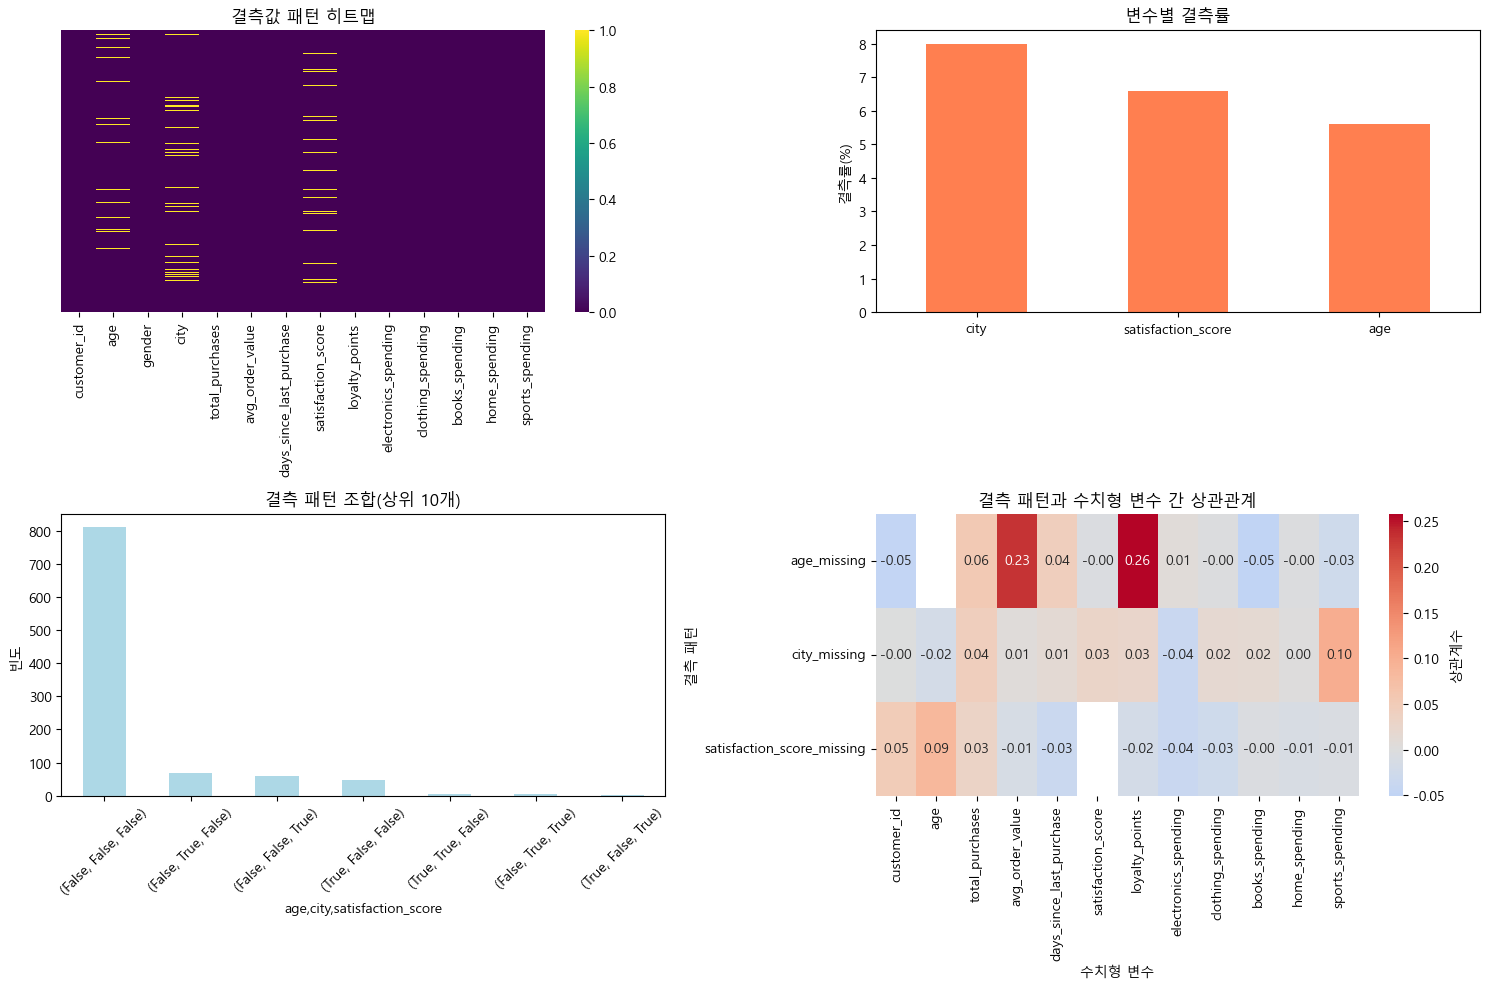

In [3]:
# 결측치 패턴 분석

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display

warnings.filterwarnings('ignore')

# 한글 폰트 설정 (선택사항)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

def analyze_missing_patterns(df: pd.DataFrame):
    """결측값 패턴 종합 분석"""
    
    print('=== 결측값 패턴 분석 ===')
    missing_info = df.isna().sum()
    missing_pct = (missing_info / len(df)) * 100
    missing_summary = pd.DataFrame({
        '결측수': missing_info,
        '결측률(%)': missing_pct.round(2),
    })
    missing_summary = missing_summary[missing_summary['결측수'] > 0].sort_values('결측수', ascending=False)
    print('변수별 결측 현황')
    display(missing_summary)
    fig, axes = plt.subplots(2, 2, figsize=(15,10))
    a1, a2, a3, a4 = axes[0,0], axes[0,1], axes[1,0], axes[1,1]
    
    # 1. 결측값 히트맵
    sns.heatmap(df.isna(), yticklabels=False, cbar=True, cmap='viridis', ax=a1)
    a1.set_title('결측값 패턴 히트맵')
    
    # 2. 변수별 결측률 바 차트
    if len(missing_summary) > 0:  # >0은 생략 가능(내용이 있다면)
        missing_summary['결측률(%)'].plot(kind='bar', color='coral', ax=a2)
        a2.set_title('변수별 결측률')    
        a2.set_ylabel('결측률(%)')
        a2.tick_params(axis='x', rotation=0)
    
    # 3. 결측값 조합 패턴 - 결측이 동시에 발생하는 변수 파악 후 유의미하게 많으면 연관을 생각할 수 있음 -> 4번에서 그룹별로 처리 가능
    '''
    df.isna().any()                           -> 컬럼에 결측값이 있으면 True, 없으면 False
    df.columns[df.isna().any()]               -> 결측값이 있는 컬럼명을 추출
    df[df.columns[df.isna().any()]]           -> 결측값이 있는 컬럼의 전체값을 추출함
    df[df.columns[df.isna().any()]].isna()    -> 결측값이라면 True로 설정함
    결측값이 있는 age, city, satisfaction_score 간에 어떤 조합이 가장 많은지 파악
    '''
    missing_pattern = df[df.columns[df.isna().any()]].isna()
    if len(missing_pattern):
        pattern_counts = missing_pattern.value_counts().head(10)
        pattern_counts.plot(kind='bar', color='lightblue', ax=a3)
        a3.set_title('결측 패턴 조합(상위 10개)')
        a3.set_ylabel('빈도')
        a3.tick_params(axis='x', rotation=45)


    # 4. 결측 변수별 결측 여부(0/1)와 다른 수치형 변수 간 상관관계 히트맵 시각화
    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    missing_cols = df.columns[df.isna().any()].tolist()

    if len(numeric_cols) > 0 and len(missing_cols) > 0:
        # 결측값을 0/1로 변환한 DataFrame 생성
        missing_binary = df[missing_cols].isna().astype(int)
        missing_binary.columns = [f'{col}_missing' for col in missing_binary.columns]
        
        # 수치형 변수와 결측 패턴 변수 결합
        corr_data = pd.concat([df[numeric_cols], missing_binary], axis=1)
        
        # 상관계수 계산
        correlation_matrix = corr_data.corr()
        
        # 결측 패턴 변수와 수치형 변수 간의 상관관계만 추출
        missing_numeric_corr = correlation_matrix.loc[
            missing_binary.columns, 
            numeric_cols
        ]
        
        # 상관관계가 있는 경우에만 히트맵 그리기
        if missing_numeric_corr.shape[0] > 0 and missing_numeric_corr.shape[1] > 0:
            sns.heatmap(
                    missing_numeric_corr, 
                    annot=True, 
                    cmap='coolwarm', 
                    center=0,
                    fmt='.2f',
                    ax=a4,
                    cbar_kws={'label': '상관계수'},
                )
            a4.set_title('결측 패턴과 수치형 변수 간 상관관계')
            a4.set_xlabel('수치형 변수')
            a4.set_ylabel('결측 패턴')
        else:
            a4.text(0.5, 0.5, '분석할 상관관계 없음', ha='center', va='center')
            a4.axis('off')
    else:
        a4.text(0.5, 0.5, '수치형 변수 또는\n결측값이 없음', ha='center', va='center')
        a4.axis('off')

    
    plt.tight_layout()
    plt.show()
    
analyze_missing_patterns(ecommerce)

=== 결측값 패턴 분석 ===
변수별 결측 현황


,결측수,결측률(%)
city,80,8.0
satisfaction_score,66,6.6
age,56,5.6


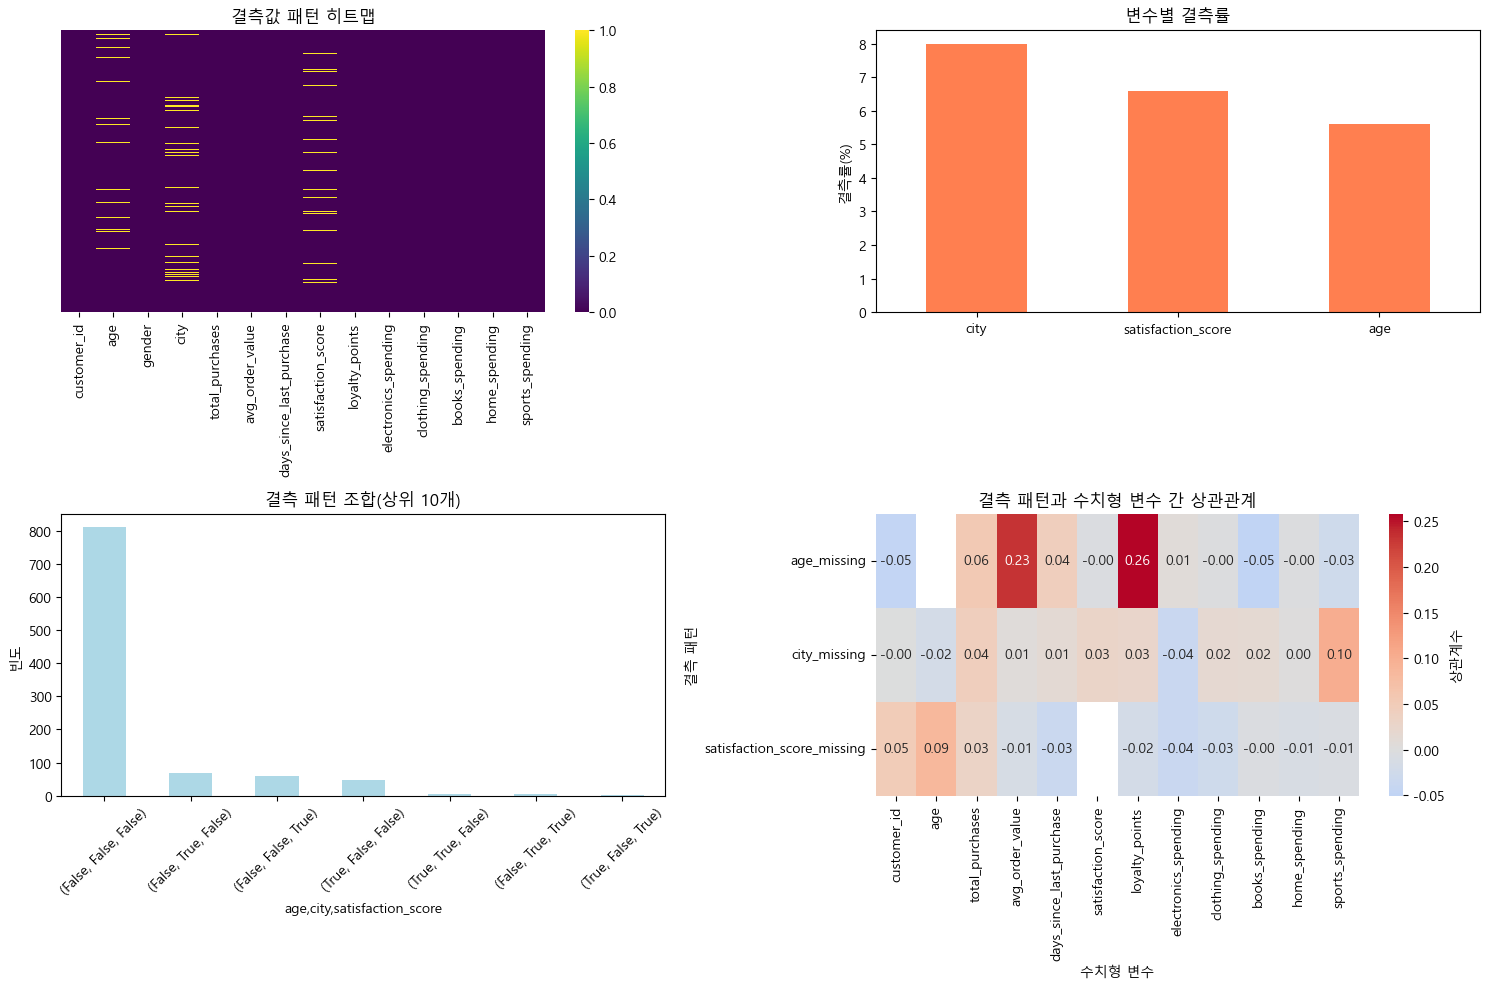

In [4]:
# 파이썬 모듈에서 불러오기

from da_utils.patterns import analyze_missing_patterns
analyze_missing_patterns(ecommerce)

In [5]:
# 결측 메커니즘 진단
from scipy.stats import chi2_contingency


print('=== 결측 메커니즘 진단 ===')

# MAR(조건부) 패턴
# 가설: 나이 결측과 구매액 간 관계
if ecommerce['age'].isna().sum():
    print('\n1. 나이(age) 결측 메커니즘 분석')

    # 구매액 분위별 나이 결측률
    df_temp = ecommerce.copy()
    df_temp['spending_quertile'] = pd.qcut(df_temp['avg_order_value'].dropna(), q=4, labels=['4분위', '3분위', '2분위', '1분위'])
    age_missing_by_spending = df_temp.groupby('spending_quertile')['age'].apply(lambda x: x.isnull().mean())  # 분위별로 그룹을 짓고, 그룹별로 각 값에 isnull(T/F로 변환)을 적용 후 평균(T/F는 1/0)을 계산
    print('\n 💲구매액 분위별 나이 결측률')
    for key, value in age_missing_by_spending.items():
        print(f' {key}: {value:.1%}')
        
    con_table = pd.crosstab(df_temp['spending_quertile'], df_temp['age'].isnull())
    chi2, p_value, _, _ = chi2_contingency(con_table)

    # print(f'\n카이^2 통계량: {chi2:.3f}, p-value: {p_value:.4f}')
    if p_value < 0.05:
        print(' ✅MAR 확인: 구매액에 따라 나이 결측률이 유의미하게 다름')
    else:
        print(' ❌MCAR 가능성 있음: 구매액과 나이 결측률은 서로 독립적')

else:
    print(' 나이(age) 결측 없음')
    
    
# 만족도 결측 패턴 분석
print('\n2. 만족도(satisfaction_score) 결측 메커니즘 분석')

if ecommerce['satisfaction_score'].isna().sum():
    # 연령대별 만족도 결측률 [0, 30, 50, 100] - [청년층(~30), 중년층(31~50), 노년층(51~)]
    # 각 구간마다 만족도가 없는 사람들의 %를 구해서 print
    print('\n 🧓연령별 만족도 결측률')
    df_temp = ecommerce.copy()
    df_temp['age_group'] = pd.cut(df_temp['age'].dropna(), bins=[0, 30, 50, 200], labels=['청년층', '중년층', '노년층'])
    satisfaction_missing_by_age = df_temp.groupby('age_group')['satisfaction_score'].apply(lambda x: x.isnull().sum() / len(x))

    for key, value in satisfaction_missing_by_age.items():
        print(f' {key}: {value:.1%}')

    con_table = pd.crosstab(df_temp['age_group'], df_temp['satisfaction_score'].isnull())
    chi2, p_value, _, _ = chi2_contingency(con_table)

    if p_value < 0.05:
        print(' ✅MAR 확인: 연령에 따라 만족도 결측률이 유의미하게 다름')
    else:
        print(' ❌MCAR 가능성 있음: 연령과 만족도 결측률은 서로 독립적')


    # 성별별 만족도 결측률도
    print('\n ♂️성별별 만족도 결측률')

    df_temp = ecommerce.copy()
    satisfaction_missing_by_gender = df_temp.groupby('gender')['satisfaction_score'].apply(lambda x: x.isnull().sum() / len(x))

    for key, value in satisfaction_missing_by_gender.items():
        print(f' {key}: {value:.1%}')


    con_table = pd.crosstab(df_temp['gender'], df_temp['satisfaction_score'].isnull())
    chi2, p_value, _, _ = chi2_contingency(con_table)

    if p_value < 0.05:
        print(' ✅MAR 확인: 성별에 따라 만족도 결측률이 유의미하게 다름')
    else:
        print(' ❌MCAR 가능성 있음: 성별과 만족도 결측률은 서로 독립적')
        
else:
    print(' 만족도 결측 없음')

=== 결측 메커니즘 진단 ===

1. 나이(age) 결측 메커니즘 분석

 💲구매액 분위별 나이 결측률
 4분위: 0.0%
 3분위: 0.0%
 2분위: 0.0%
 1분위: 22.4%
 ✅MAR 확인: 구매액에 따라 나이 결측률이 유의미하게 다름

2. 만족도(satisfaction_score) 결측 메커니즘 분석

 🧓연령별 만족도 결측률
 청년층: 4.0%
 중년층: 5.8%
 노년층: 20.4%
 ✅MAR 확인: 연령에 따라 만족도 결측률이 유의미하게 다름

 ♂️성별별 만족도 결측률
 F: 5.6%
 M: 7.9%
 ❌MCAR 가능성 있음: 성별과 만족도 결측률은 서로 독립적


## 고급 결측값 대체 기법

원본데이터 결측률
  age: 5.60%
  satisfaction_score: 6.60%


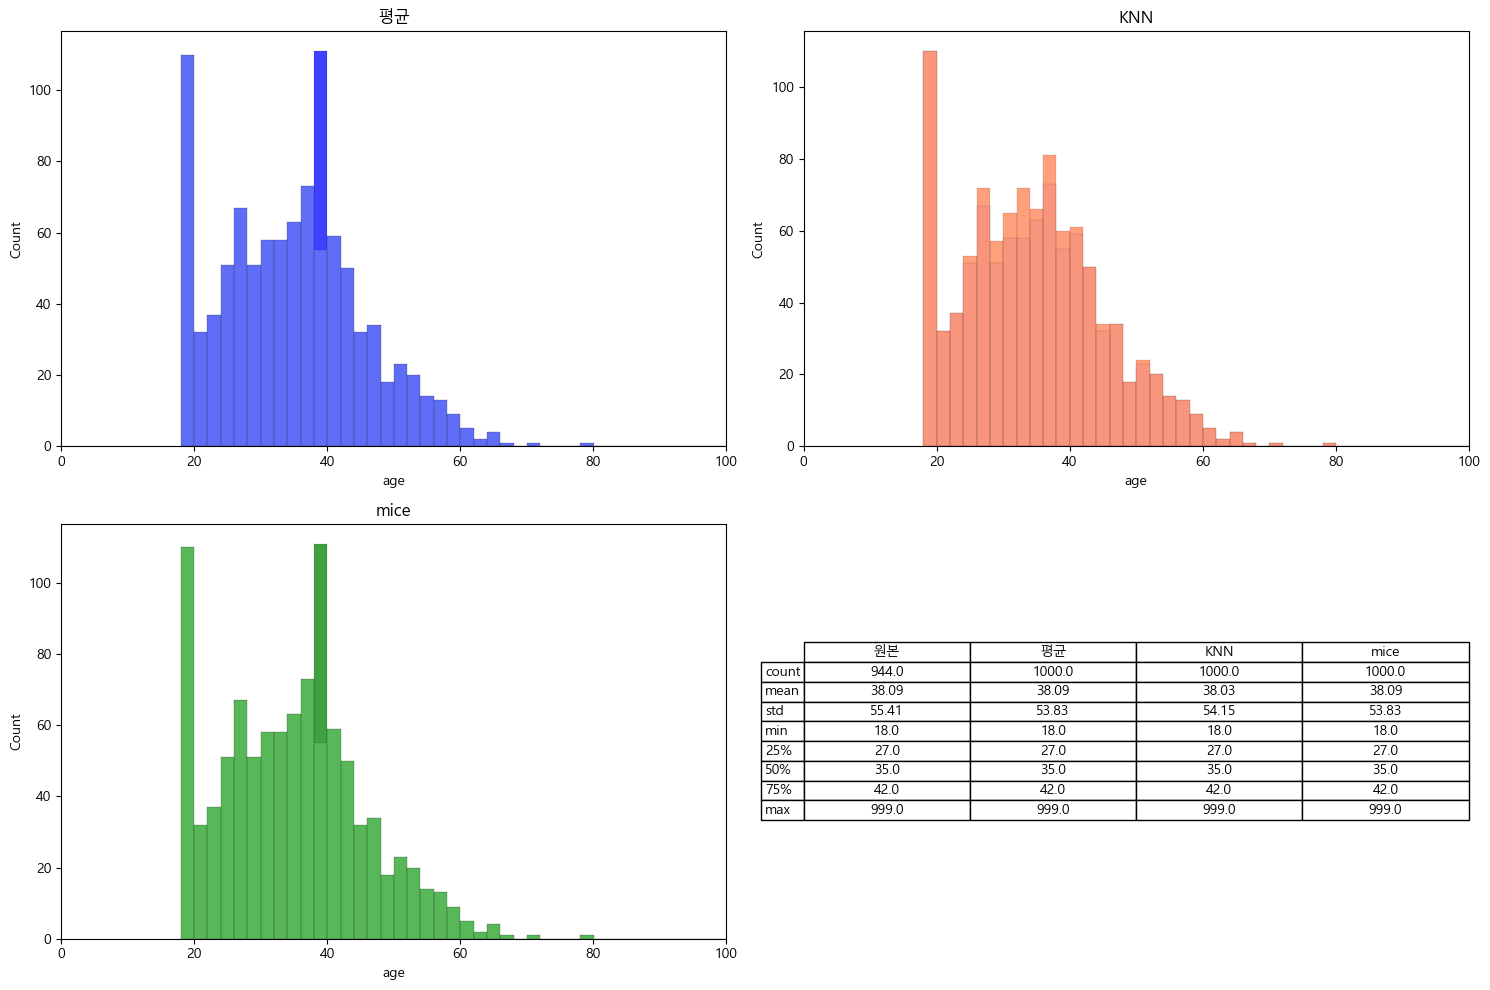

In [6]:
# impute: 대체하다
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# 숫자형 컬럼만 뽑기
numeric_cols = ['age', 'total_purchases', 'avg_order_value', 'days_since_last_purchase', 'satisfaction_score', 'loyalty_points']
df_numeric = ecommerce[numeric_cols]
print('원본데이터 결측률')
for col in numeric_cols:
    missing_rate = df_numeric[col].isnull().mean()
    if missing_rate:
        print(f'  {col}: {missing_rate:.2%}')

# 1. 결측에 전부 평균을 집어넣었음
imputer_mean = SimpleImputer(strategy='mean')
df_mean = df_numeric.copy()
df_mean[numeric_cols] = imputer_mean.fit_transform(df_numeric[numeric_cols])


# 2. KNN 대체 - K Nearest Neighbors, 결측값과 가장 가까운 n명을 뽑아서 그 사람들의 평균을 구함
imputer_knn = KNNImputer(n_neighbors=5)
df_knn = df_numeric.copy()
df_knn[numeric_cols] = imputer_knn.fit_transform(df_numeric[numeric_cols])


# 3. MICE 대체 - Multiple Imputation by Chained Equations, 결측변수를 다른 변수를 써서 회귀모델 예측
imputer_mice = IterativeImputer(random_state=42, max_iter=10)
df_mice = df_numeric.copy()
df_mice[numeric_cols] = imputer_mice.fit_transform(df_numeric[numeric_cols])

# age 변수의 대체결과 비교 시각화
fig, axes = plt.subplots(2, 2, figsize=(15,10))
a1, a2, a3, a4 = axes[0,0], axes[0,1], axes[1,0], axes[1,1]

variable = 'age'
if df_numeric[variable].isnull().sum():
    
    sns.histplot(df_mean[variable], binwidth=2, kde=False, ax=a1, label='평균', color='blue')
    sns.histplot(df_numeric[variable], binwidth= 2, kde=False, ax=a1, label='원본', color='lightblue', alpha=0.3)
    a1.set_xlim(0, 100)
    a1.set_title('평균')
        
    sns.histplot(df_knn[variable], binwidth= 2, kde=False, ax=a2, label = 'KNN', color='coral')
    sns.histplot(df_numeric[variable], binwidth= 2, kde=False, ax=a2, label='원본', color='lightcoral', alpha=0.3)
    a2.set_xlim(0, 100)
    a2.set_title('KNN')

    sns.histplot(df_mice[variable], binwidth= 2, kde=False, ax=a3, label = 'mice', color='green')
    sns.histplot(df_numeric[variable], binwidth= 2, kde=False, ax=a3, label='원본', color='lightgreen', alpha=0.3)
    a3.set_xlim(0, 100)
    a3.set_title('mice')
    
    
    # 대체 전후 통계량 비교
    comparison_stats = pd.DataFrame({
        '원본': df_numeric[variable].describe(),
        '평균': df_mean[variable].describe(),
        'KNN': df_knn[variable].describe(),
        'mice': df_mice[variable].describe(),
    }).round(2)
    
    # 텍스트로 통계 비교 표시
    a4.axis('off')
    a4.table(
        cellText=comparison_stats.values,
        rowLabels=comparison_stats.index,
        colLabels=comparison_stats.columns,
        cellLoc='center',
        loc='center',
    )
    
    plt.tight_layout()
    plt.show()

## 대체 품질 평가

In [7]:
print('=== 대체 품질 평가 ===')
dist_evaluation_results = []
corr_evaluation_results = []
original_df = df_numeric
imputed_dfs = [df_mean, df_knn, df_mice ]
method_names = ['평균대체', 'KNN대체', 'MICE대체']

for method_name, imputed_df in zip(method_names, imputed_dfs):
    
    for col in ['age','satisfaction_score']:
        # 1. 분포 유사성 평가
        # 결측치가 있는 경우만
        if original_df[col].isnull().sum():
            
            original_stats = original_df[col].dropna().describe()
            imputed_stats = imputed_df[col].describe()
            
            # 평균차이
            mean_diff = abs(original_stats['mean'] - imputed_stats['mean']) / original_stats['mean'] * 100
            # 표준편차차이
            std_diff = abs(original_stats['std'] - imputed_stats['std']) / original_stats['std'] * 100
            
            dist_evaluation_results.append({
                '방법': method_name,
                '변수': col,
                '평균차이(%)': mean_diff,
                '표준편차차이(%)': std_diff,
            })

        # 2. 다른 변수와의 상관관계 보존 평가 - age, satisfaction_score <-> average_order_value
        # 이건 실제로 상관관계가 있는 걸로 평가해야 함
            original_corr = original_df[[col, 'avg_order_value']].corr().iloc[0, 1]  # 결측치 포함
            imputed_corr = imputed_df[[col, 'avg_order_value']].dropna().corr().iloc[0, 1]  # 결측치 대체
        
            # 상관관계 유지도
            corr_preservation = abs(original_corr - imputed_corr) / abs(original_corr) * 100
            
            corr_evaluation_results.append({
                '방법': method_name,
                '변수': f'{col}-구매액 상관관계',
                '원본상관계수': original_corr,
                '대체상관계수': imputed_corr,
                '상관계수보존도(%)': 100 - corr_preservation,
            })
        
print('\n1. 분포 보존 성능')
dist_eval = pd.DataFrame(dist_evaluation_results) 
display(dist_eval)

print('\n2. 상관관계 보존 성능')
corr_eval = pd.DataFrame(corr_evaluation_results)
for _, row in corr_eval.iterrows():
    print(f'{row['방법']}: 보존도 {row['상관계수보존도(%)']:.1f}%')
    print(f'(원본: {row['원본상관계수']:.3f} → 대체후: {row['대체상관계수']:.3f})')

=== 대체 품질 평가 ===

1. 분포 보존 성능


,방법,변수,평균차이(%),표준편차차이(%)
0,평균대체,age,1.865429e-14,2.843222
1,평균대체,satisfaction_score,0.000000e+00,3.359743
2,KNN대체,age,1.508068e-01,2.263812
3,KNN대체,satisfaction_score,2.318097e-03,2.841924
4,MICE대체,age,1.597489e-03,2.843222
5,MICE대체,satisfaction_score,1.346629e-02,3.352197



2. 상관관계 보존 성능
평균대체: 보존도 94.9%
(원본: -0.000 → 대체후: -0.000)
평균대체: 보존도 98.9%
(원본: -0.046 → 대체후: -0.045)
KNN대체: 보존도 -828.7%
(원본: -0.000 → 대체후: -0.004)
KNN대체: 보존도 96.6%
(원본: -0.046 → 대체후: -0.047)
MICE대체: 보존도 89.5%
(원본: -0.000 → 대체후: -0.000)
MICE대체: 보존도 98.7%
(원본: -0.046 → 대체후: -0.046)


## 이상값 탐지 및 처리

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from scipy.spatial import distance
from scipy.stats import chi2
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

# 경고메세지 무시
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


# 범용 이상치 탐지 함수
def outlier_detection(df: pd.DataFrame, chi_q=0.999, iso_contamination=0.1, final_threshold=2):
    print('=== 종합 이상값 탐지 ===')
    df_copy = df.copy()
    numeric_data = df_copy.select_dtypes(include=['number'])
    
    # 1. IQR 이상값(일(단)변량 이상값 탐지) - 변수 하나를 가지고 확인
        # 특정 컬럼 안에서 다른 값들에 비해 값이 이상한 걸 탐지함
    print('\n1. 일변량 이상값 탐지(IQR법)')
    univariate_outliers = pd.DataFrame(index=df_copy.index)
    
    for col in numeric_data.columns:
        Q1 = df_copy[col].quantile(0.25)
        Q3 = df_copy[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers_mask = (df_copy[col] < lower_bound) | (df_copy[col] > upper_bound)
        univariate_outliers[col] = outliers_mask
        
        outlier_count = outliers_mask.sum()
        if outlier_count:
            print(f'  {col}: {outlier_count}개 ({outlier_count/len(df_copy) * 100:.1f}%)')

    # 2. 마할라노비스 거리 기반 다변량 이상값
        # 변수 간의 스케일 차이와 상관관계까지 고려해 이상값을 확인
        # 특정 컬럼이 이상한게 아니라, 종합적으로 데이터 행 하나하나가 이상한가를 보여준다
        # 데이터가 정규분포를 따를 때 유용함(데이터가 대부분 정상으로 보이지만, 이상값을 찾고 싶을 때 사용) - 대놓고 이상한 데이터가 한가득일 때는 제대로 작동 안함. 
    print('\n2. 다변량 이상값 탐지(마할라노비스 거리)')
    
    # 변수 간 스케일 차이 변환
        # standard scaler - 모든 데이터를 표준편차 1, 평균 0으로 바꿔버림
    scaler = StandardScaler()
    scaled_df = pd.DataFrame(
        scaler.fit_transform(numeric_data),
        columns=numeric_data.columns,
        index=numeric_data.index,
    )
    # 데이터 평균 벡터
    mean = scaled_df.mean().values
    # 공분산 행렬
    cov_matrix = np.cov(scaled_df, rowvar=False)
    # 공분산 행렬의 역행렬
    inv_cov_matrix = np.linalg.pinv(cov_matrix)
    
    # 마할라노비스 거리 계산
    mahalanobis_dist = scaled_df.apply(lambda row: distance.mahalanobis(row, mean, inv_cov_matrix), axis=1)
    
    # 이상치 기준점(threshold) 지정 (카이제곱 분포 -> 정상값을 몇 퍼센트(95% / 99% / 99.9%)까지 인정할 수 있는가)
    threshold = chi2.ppf(chi_q, len(numeric_data.columns)) ** 0.5
    mahalanobis_outliers = mahalanobis_dist > threshold
    print(f'  임계값: {threshold:.2f}')
    print(f'  마할라노비스 거리 이상값: {mahalanobis_outliers.sum()}개 ({mahalanobis_outliers.mean() * 100:.1f}%)')
    
    # 3. Isolation Forest 기반 다변량 이상값
        # 랜덤한 기준으로 구분하는 독립된 Tree 여러개를 만들어서 얼마나 빨리 고립되는지를 확인하는 과정
        # 데이터 간의 관계가 복잡해 이상치가 복잡하게 숨어있을 때 이용함 - 매우 공격적으로 이상치를 검출, 대놓고 수상한 데이터들을 잘 골라준다
    print('\n3. 다변량 이상값 탐지(Isolation Forest)')
    # contamination = 전체에서 얼마나 이상값 비율이 있을것인가 예측. 'auto'로 알아서 고르라 할 수 있다.
    iso_forest = IsolationForest(contamination=iso_contamination, random_state=42)
    iso_outliers = iso_forest.fit_predict(scaled_df) == -1
    iso_scores = iso_forest.score_samples(scaled_df)
    print(f'  Isolation Forest 이상값: {iso_outliers.sum()}개 ({iso_outliers.mean() * 100:.1f}%)')    
    
    # 4. 비즈니스 규칙(특화) 이상값
        # 굳이 복잡한 방법을 쓰지 말고, 각 컬럼별로 이상값 기준을 정해준 뒤 그 기준에 맞지 않으면 이상값으로 판정(사람은 130살 이상 살기 힘듦)
        # 각 데이터마다 전용 기준이 필요함
        
    print('\n4. 비즈니스 규칙 기반 이상값 탐지')
    business_outliers = (
        (df['age'] > 130) |
        (df['days_since_last_purchase'] < 0) |
        (df['avg_order_value'] < 0)
    )
    print(f'  비즈니스 규칙 이상값: {business_outliers.sum()}개 ({business_outliers.mean() * 100:.1f}%)')
    
    # 종합 판정
    outlier_summary = pd.DataFrame({
        'IQR': univariate_outliers.sum(axis=1) > 0,
        '마할라노비스 거리': mahalanobis_outliers,
        'Isolation Forest': iso_outliers,
        '비즈니스': business_outliers,
    })
    
    outlier_summary['총이상값수'] = outlier_summary.sum(axis=1)
    final_outliers = (outlier_summary['총이상값수'] >= final_threshold) | (business_outliers)
    print(f'\n == 최종 이상값: {final_outliers.sum()}개 ({final_outliers.mean() * 100:.1f}%)')
    
    return outlier_summary, final_outliers
    
summary, final_outliers = outlier_detection(df_knn, chi_q=0.999, iso_contamination='auto', final_threshold=2)

=== 종합 이상값 탐지 ===

1. 일변량 이상값 탐지(IQR법)
  age: 11개 (1.1%)
  avg_order_value: 70개 (7.0%)
  days_since_last_purchase: 48개 (4.8%)
  loyalty_points: 37개 (3.7%)

2. 다변량 이상값 탐지(마할라노비스 거리)
  임계값: 4.74
  마할라노비스 거리 이상값: 14개 (1.4%)

3. 다변량 이상값 탐지(Isolation Forest)
  Isolation Forest 이상값: 136개 (13.6%)

4. 비즈니스 규칙 기반 이상값 탐지
  비즈니스 규칙 이상값: 6개 (0.6%)

 == 최종 이상값: 89개 (8.9%)


=== 이상값 해석 및 처리 전략 ===

1. 이상값 vs 정상값 비교 분석


,정상고객_평균,이상값고객_평균,정상고객_중위수,이상값고객_중위수,차이배수
age,35.08,68.94,35.00,38.10,1.97
total_purchases,8.88,9.47,9.00,9.00,1.07
avg_order_value,103.19,388.95,83.26,335.16,3.77
days_since_last_purchase,26.45,64.82,18.00,50.00,2.45
loyalty_points,107.67,375.76,87.00,301.00,3.49



2. 이상값 분류 및 처리 전략
  VIP 고객 (특별 관리 대상): 41명
  데이터 오류 (수정/제거 필요): 5명
  극단적 구매액 (윈저화 필요): 10명
  휴면 고객 (재활성화 대상): 36명


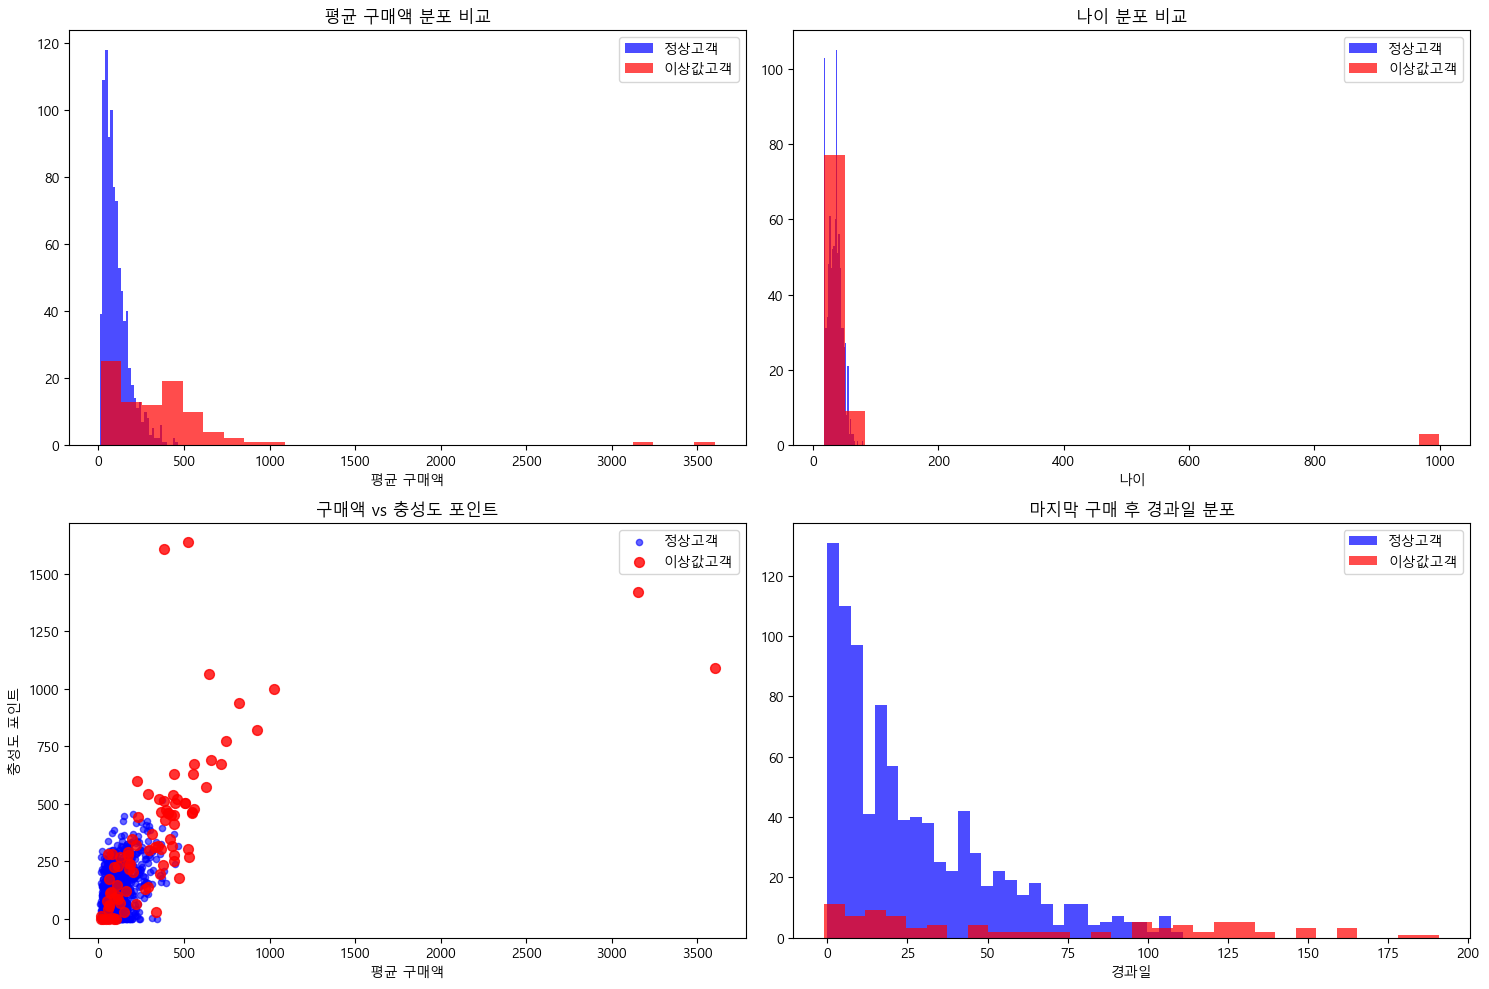

In [15]:
# 이상값 해석

def outlier_interpretation_strategy(df, outliers_mask):
    """이상값 해석 및 처리 전략 수립"""
    
    print("=== 이상값 해석 및 처리 전략 ===")
    
    # 이상값 특성 분석
    normal_customers = df[~outliers_mask]
    outlier_customers = df[outliers_mask]
    
    if len(outlier_customers) == 0:
        print("이상값이 없습니다.")
        return
    
    print("\n1. 이상값 vs 정상값 비교 분석")
    
    comparison_vars = ['age', 'total_purchases', 'avg_order_value', 'days_since_last_purchase', 'loyalty_points']
    
    comparison_stats = pd.DataFrame({
        '정상고객_평균': normal_customers[comparison_vars].mean(),
        '이상값고객_평균': outlier_customers[comparison_vars].mean(),
        '정상고객_중위수': normal_customers[comparison_vars].median(),
        '이상값고객_중위수': outlier_customers[comparison_vars].median()
    }).round(2)
    
    comparison_stats['차이배수'] = (comparison_stats['이상값고객_평균'] / comparison_stats['정상고객_평균']).round(2)
    
    display(comparison_stats)
    
    # 2. 이상값 분류 및 처리 전략
    print(f"\n2. 이상값 분류 및 처리 전략")
    
    # VIP 고객 (높은 구매액 + 높은 충성도)
    vip_mask = (outlier_customers['avg_order_value'] > normal_customers['avg_order_value'].quantile(0.95)) & \
               (outlier_customers['loyalty_points'] > normal_customers['loyalty_points'].quantile(0.95))
    vip_count = vip_mask.sum()
    
    # 데이터 오류 (나이 999살, 음수 날짜 등)
    error_mask = (outlier_customers['age'] > 130) | (outlier_customers['age'] < 0) | (outlier_customers['days_since_last_purchase'] < 0)
    error_count = error_mask.sum()
    
    # 극단적 구매액 (상위 1%)
    winsor_threshold = df['avg_order_value'].quantile(0.99)
    extreme_purchase_mask = outlier_customers['avg_order_value'] >= winsor_threshold
    extreme_purchase_count = extreme_purchase_mask.sum()
    
    # 이상 행동 고객 (오랫동안 구매 없음)
    dormant_mask = outlier_customers['days_since_last_purchase'] > normal_customers['days_since_last_purchase'].quantile(0.95)
    dormant_count = dormant_mask.sum()
    
    print(f"  VIP 고객 (특별 관리 대상): {vip_count}명")
    print(f"  데이터 오류 (수정/제거 필요): {error_count}명")
    print(f"  극단적 구매액 (윈저화 필요): {extreme_purchase_count}명") 
    print(f"  휴면 고객 (재활성화 대상): {dormant_count}명")
    
    # 시각화 (소문자 변수명 사용)
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    a1, a2, a3, a4 = axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]
    # 구매액 분포 비교
    a1.hist(normal_customers['avg_order_value'], bins=30, alpha=0.7, label='정상고객', color='blue')
    a1.hist(outlier_customers['avg_order_value'], bins=30, alpha=0.7, label='이상값고객', color='red')
    a1.set_title('평균 구매액 분포 비교')
    a1.set_xlabel('평균 구매액')
    a1.legend()
    
    # 나이 분포 비교
    a2.hist(normal_customers['age'], bins=30, alpha=0.7, label='정상고객', color='blue')
    a2.hist(outlier_customers['age'], bins=30, alpha=0.7, label='이상값고객', color='red')
    a2.set_title('나이 분포 비교')
    a2.set_xlabel('나이')
    a2.legend()
    
    # 구매액 vs 충성도 포인트 산점도
    a3.scatter(normal_customers['avg_order_value'], normal_customers['loyalty_points'], 
                     alpha=0.6, label='정상고객', color='blue', s=20)
    a3.scatter(outlier_customers['avg_order_value'], outlier_customers['loyalty_points'], 
                     alpha=0.8, label='이상값고객', color='red', s=50)
    a3.set_xlabel('평균 구매액')
    a3.set_ylabel('충성도 포인트')
    a3.set_title('구매액 vs 충성도 포인트')
    a3.legend()
    
    # 마지막 구매 후 경과일 분포
    a4.hist(normal_customers['days_since_last_purchase'], bins=30, alpha=0.7, label='정상고객', color='blue')
    a4.hist(outlier_customers['days_since_last_purchase'], bins=30, alpha=0.7, label='이상값고객', color='red')
    a4.set_title('마지막 구매 후 경과일 분포')
    a4.set_xlabel('경과일')
    a4.legend()
    
    plt.tight_layout()
    plt.show()

# 이상값 해석 및 전략 수립
outlier_interpretation_strategy(df_mice, final_outliers)

In [46]:
# 이상값 처리
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer



def execute_outlier_treatment(df:pd.DataFrame, outlier_mask):
    print('=== 이상값 처리 실행 ===')
    df_treated = df.copy()
    outliers = df[outlier_mask]
    normal_customers = df[~outlier_mask]

    
    if len(outliers) == 0:
        print('\n처리할 이상값 없음')
        return df_treated
    
    print(f'\n처리 대상 이상값: {len(outliers)}개')
    # 1. VIP 고객 처리 (별도 세그먼트로 분리)
    vip_mask = (outliers['avg_order_value'] > normal_customers['avg_order_value'].quantile(0.95)) & \
               (outliers['loyalty_points'] > normal_customers['loyalty_points'].quantile(0.95))
    # VIP 인덱스
    vip_indices = outliers[vip_mask].index
    # VIP인 행들만 뽑고, 해당 사람들에만 컬럼(customer_segment)-값(VIP) 추가함
    df_treated.loc[vip_indices, 'VIP'] = True
    df_treated['VIP'] = df_treated['VIP'].fillna(False)

    print(f'- VIP 고객 분리 완료: {len(vip_indices)}개')
    
    # 2. 데이터 입력 오류 수정(결측치로 대체, 윈저화, 등등등) - 미리 이상치 체크해놓은 대로 해줘야함
    
    # 2-1. 너무 이상한 값(나이 999같은)은 결측으로 바꿀 것
    age_error_mask = (df['age'] > 130) | (df['age'] < 0)
    age_error_indices = df[age_error_mask].index
    df_treated.loc[age_error_indices, 'age'] = np.nan
    print(f'- 나이 오류 결측처리: {len(age_error_indices)}개')

    # 2-1-1. 다시 결측치 채우기
    if df_treated['age'].isnull().sum():
        age_imputer = KNNImputer(n_neighbors=5)
        # "비슷함"을 정의한 컬럼들
        cols = ['avg_order_value', 'days_since_last_purchase', 'loyalty_points']
        impute_data = df_treated[['age'] + cols]
        # 나머지 세 컬럼을 기준으로 age 컬럼을 추론함
        imputed = age_imputer.fit_transform(impute_data)    
        # 추론한 age 컬럼을 다시 원래 컬럼에 집어넣음
        df_treated['age'] = imputed[:, 0]
        print('  >> 추가 결측치는 KNN대체')
        
    # 2-2. 음수 일수는 0으로 변경
    days_error_mask = outliers['days_since_last_purchase'] < 0
    days_error_indices = outliers[days_error_mask].index
    df_treated.loc[days_error_indices, 'days_since_last_purchase'] = 0
    print(f'- 음수 일수는 0으로 변경: {len(days_error_indices)}개')

    # 2-2. 극단적 구매액 처리(윈저화 99%)
    winsor_threshold = df_treated['avg_order_value'].quantile(0.99)
    extreme_purchases_mask = outliers['avg_order_value'] >= winsor_threshold
    extreme_purchases_indices = outliers[extreme_purchases_mask].index
    df_treated.loc[extreme_purchases_indices, 'avg_order_value'] = winsor_threshold
    print(f'- 극단적 구매액 윈저화: {len(extreme_purchases_indices)}개')
    print(f'  >> 윈저화 기준: {winsor_threshold:.2f} 이상')
    
    # 3. 휴면 고객 처리 (별도 플래그 생성)
    dormant_mask = outliers['days_since_last_purchase'] >= normal_customers['days_since_last_purchase'].quantile(0.95)
    dormant_indices = outliers[dormant_mask].index
    df_treated.loc[dormant_indices, 'status'] = '휴면고객'
    df_treated['status'] = df_treated['status'].fillna('활동고객')
    print(f'- 휴면고객 처리: {dormant_mask.sum()}개')
    print(f'  >> 휴면 기준: {normal_customers['days_since_last_purchase'].quantile(0.95):.0f}일 이상')

    # 4. 처리 결과 요약
    print(f'\n처리 결과 요약')
    print(f'- 원본 데이터: {len(df)}건')
    print(f'- VIP 세그먼트: {len(vip_indices)}명')
    print(f'- 휴면 고객: {len(dormant_indices)}명')
    print(f'- 활성 고객: {len(df) - len(dormant_indices)}명')
    
    return df_treated
    
df_final = execute_outlier_treatment(df_knn, final_outliers)

=== 이상값 처리 실행 ===

처리 대상 이상값: 89개
- VIP 고객 분리 완료: 41개
- 나이 오류 결측처리: 4개
  >> 추가 결측치는 KNN대체
- 음수 일수는 0으로 변경: 2개
- 극단적 구매액 윈저화: 10개
  >> 윈저화 기준: 558.44 이상
- 휴면고객 처리: 36개
  >> 휴면 기준: 78일 이상

처리 결과 요약
- 원본 데이터: 1000건
- VIP 세그먼트: 41명
- 휴면 고객: 36명
- 활성 고객: 964명


## 처리 전후 분석

=== 처리 전후 비교 분석 ===
1. 기본 통계량 변화:


,처리전_평균,처리후_평균,처리전_표준편차,처리후_표준편차,처리전_최댓값,처리후_최댓값,평균_변화율(%),표준편차_변화율(%)
age,38.09,34.94,53.83,10.86,999.0,80.00,-8.27,-79.83
total_purchases,8.94,8.94,2.63,2.63,17.0,17.00,0.00,0.00
avg_order_value,128.62,121.28,185.10,106.47,3603.4,558.44,-5.71,-42.48
days_since_last_purchase,29.86,29.86,30.66,30.65,191.0,191.00,0.00,-0.03
loyalty_points,131.53,131.53,158.52,158.52,1640.0,1640.00,0.00,0.00


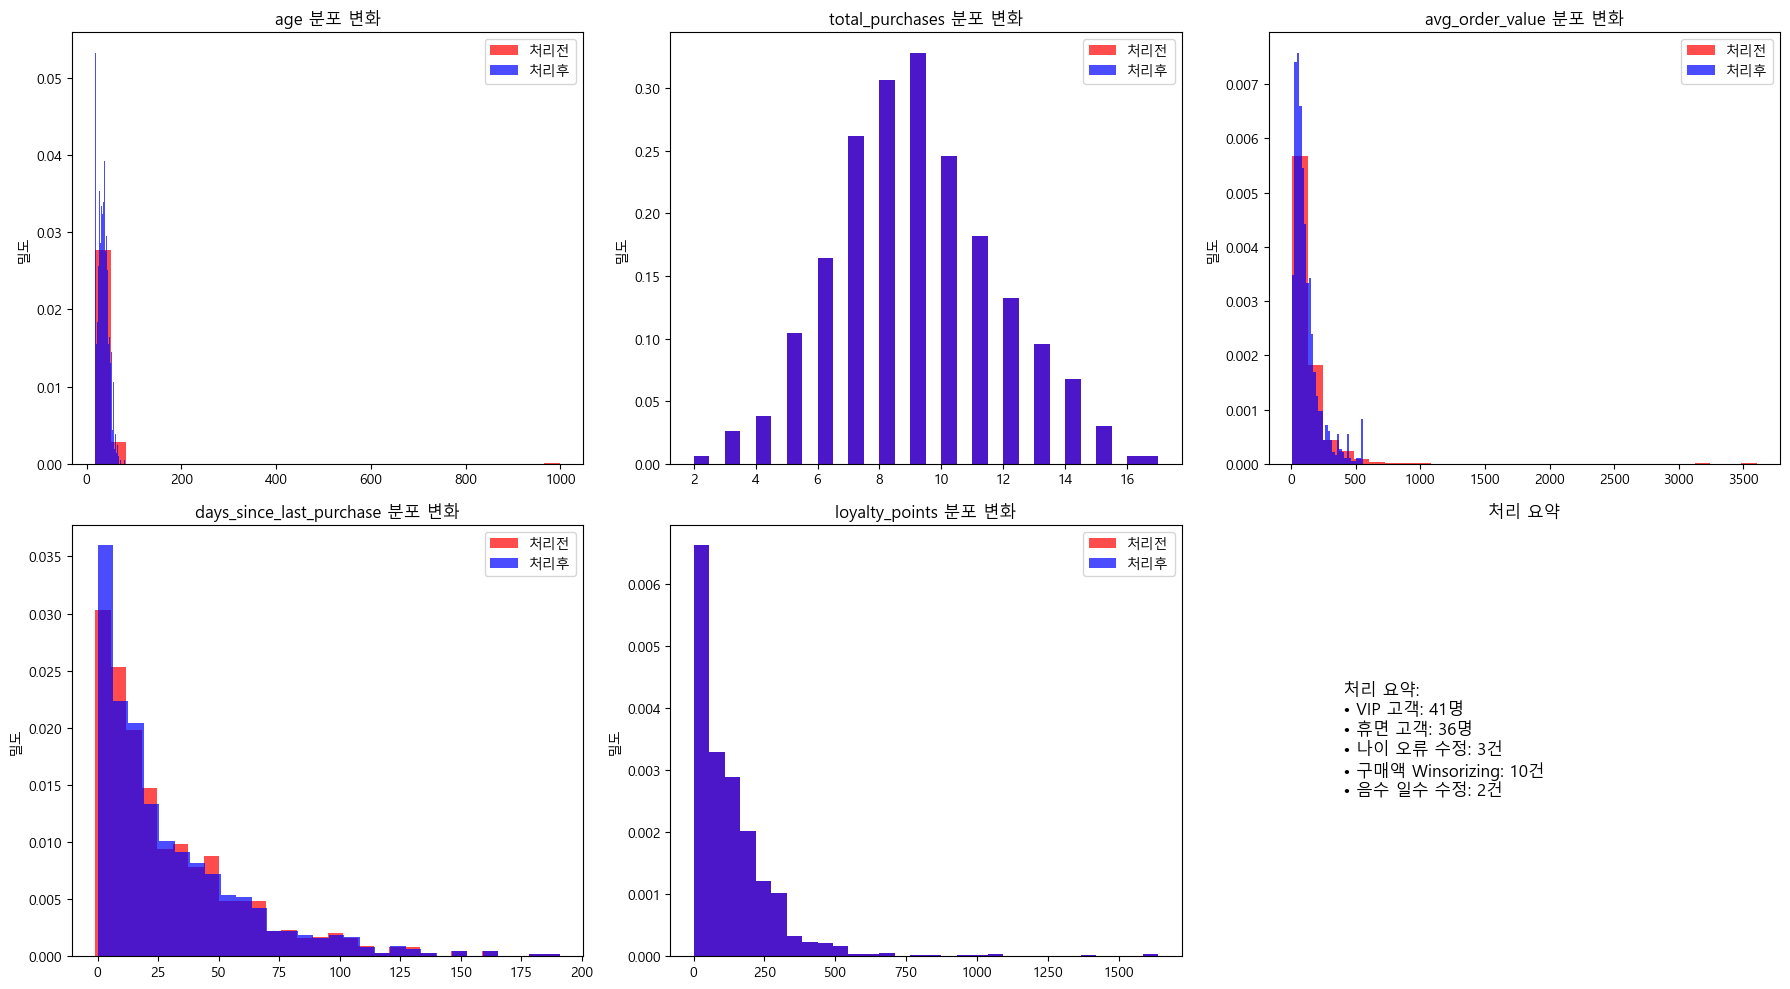


2. 분포 안정성 검증:
age:
  왜도: 17.110 → 0.439 (변화: -16.671)
  첨도: 303.702 → -0.068 (변화: -303.770)
total_purchases:
  왜도: 0.227 → 0.227 (변화: 0.000)
  첨도: -0.097 → -0.097 (변화: 0.000)
avg_order_value:
  왜도: 11.637 → 2.062 (변화: -9.575)
  첨도: 196.193 → 4.664 (변화: -191.529)
days_since_last_purchase:
  왜도: 1.688 → 1.688 (변화: 0.000)
  첨도: 3.301 → 3.301 (변화: 0.001)
loyalty_points:
  왜도: 3.606 → 3.606 (변화: 0.000)
  첨도: 23.761 → 23.761 (변화: 0.000)


In [47]:
def compare_before_after_treatment(df_original, df_treated):
    """이상값 처리 전후 비교 분석"""
    
    print("=== 처리 전후 비교 분석 ===")
    
    # 기본 통계량 비교
    numeric_cols = ['age', 'total_purchases', 'avg_order_value', 'days_since_last_purchase', 'loyalty_points']
    
    comparison = pd.DataFrame({
        '처리전_평균': df_original[numeric_cols].mean(),
        '처리후_평균': df_treated[numeric_cols].mean(),
        '처리전_표준편차': df_original[numeric_cols].std(),
        '처리후_표준편차': df_treated[numeric_cols].std(),
        '처리전_최댓값': df_original[numeric_cols].max(),
        '처리후_최댓값': df_treated[numeric_cols].max()
    }).round(2)
    
    comparison['평균_변화율(%)'] = ((comparison['처리후_평균'] - comparison['처리전_평균']) / comparison['처리전_평균'] * 100).round(2)
    comparison['표준편차_변화율(%)'] = ((comparison['처리후_표준편차'] - comparison['처리전_표준편차']) / comparison['처리전_표준편차'] * 100).round(2)
    
    print("1. 기본 통계량 변화:")
    display(comparison)
    
    # 시각화
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()
    
    for i, col in enumerate(numeric_cols):
        if i < len(axes):
            # 히스토그램 비교
            axes[i].hist(df_original[col], bins=30, alpha=0.7, label='처리전', color='red', density=True)
            axes[i].hist(df_treated[col], bins=30, alpha=0.7, label='처리후', color='blue', density=True)
            axes[i].set_title(f'{col} 분포 변화')
            axes[i].legend()
            axes[i].set_ylabel('밀도')
    
    # 마지막 서브플롯에 요약 정보
    axes[-1].axis('off')
    summary_text = f"""
    처리 요약:
    • VIP 고객: {(df_treated.get('VIP', '')).sum()}명
    • 휴면 고객: {(df_treated.get('status', '') == '휴면고객').sum()}명
    • 나이 오류 수정: {(df_original['age'] > 100).sum()}건
    • 구매액 Winsorizing: {(df_original['avg_order_value'] > df_original['avg_order_value'].quantile(0.99)).sum()}건
    • 음수 일수 수정: {(df_original['days_since_last_purchase'] < 0).sum()}건
    """
    axes[-1].text(0.1, 0.5, summary_text, fontsize=12, verticalalignment='center')
    axes[-1].set_title('처리 요약')
    
    plt.tight_layout()
    plt.show()
    
    # 분포 안정성 검증
    print(f"\n2. 분포 안정성 검증:")
    for col in numeric_cols:
        # 왜도와 첨도 변화
        skew_before = df_original[col].skew()
        skew_after = df_treated[col].skew()
        kurt_before = df_original[col].kurtosis()
        kurt_after = df_treated[col].kurtosis()
        
        print(f"{col}:")
        print(f"  왜도: {skew_before:.3f} → {skew_after:.3f} (변화: {skew_after-skew_before:.3f})")
        print(f"  첨도: {kurt_before:.3f} → {kurt_after:.3f} (변화: {kurt_after-kurt_before:.3f})")

# 비교 분석 실행
compare_before_after_treatment(df_mice, df_final)


## 비즈니스 영향 분석

In [48]:
def analyze_business_impact(df_treated):
    """이상값 처리의 비즈니스 영향 분석"""
    
    print("=== 💼 비즈니스 영향 분석 ===")
    
    # 고객 세그먼트별 분석
    if 'VIP' in df_treated.columns:
        vip_analysis = df_treated[df_treated['VIP']]
        regular_analysis = df_treated[df_treated['VIP'] == False]
        
        print("1. VIP vs 일반 고객 비교:")
        print(f"VIP 고객 수: {len(vip_analysis)}명 ({len(vip_analysis)/len(df_treated)*100:.1f}%)")
        print(f"VIP 평균 구매액: {vip_analysis['avg_order_value'].mean():,.0f}달러")
        print(f"일반 고객 평균 구매액: {regular_analysis['avg_order_value'].mean():,.0f}달러")
        print(f"VIP 매출 기여도: {(vip_analysis['avg_order_value'].sum() / df_treated['avg_order_value'].sum() * 100):.1f}%")
    
    # 고객 상태별 분석  
    if 'status' in df_treated.columns:
        status_analysis = df_treated.groupby('status').agg({
            'avg_order_value': ['count', 'mean', 'sum'],
            'days_since_last_purchase': 'mean',
            'loyalty_points': 'mean'
        }).round(2)
        
        print(f"\n2. 고객 상태별 분석:")
        display(status_analysis)
        
        # 재활성화 대상 고객 분석
        dormant_customers = df_treated[df_treated['status'] == '휴면고객']
        if len(dormant_customers) > 0:
            print(f"\n3. 휴면 고객 재활성화 기회:")
            print(f"휴면 고객 수: {len(dormant_customers)}명")
            print(f"평균 휴면 기간: {dormant_customers['days_since_last_purchase'].mean():.0f}일")
            print(f"과거 평균 구매액: {dormant_customers['avg_order_value'].mean():,.0f}원")
            print(f"재활성화 시 예상 매출: {len(dormant_customers) * dormant_customers['avg_order_value'].mean():,.0f}원")
    
    # 데이터 품질 개선 효과
    print(f"\n4. 데이터 품질 개선 효과:")
    
    # 이상값 제거로 인한 분석 안정성 향상
    orig_cv = df_mice['avg_order_value'].std() / df_mice['avg_order_value'].mean()
    treat_cv = df_treated['avg_order_value'].std() / df_treated['avg_order_value'].mean()
    
    print(f"구매액 변동계수: {orig_cv:.3f} → {treat_cv:.3f} (안정성 {(1-treat_cv/orig_cv)*100:.1f}% 향상)")
    
    # 모델링 정확도 예상 개선
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    
    # PCA로 데이터 구조 안정성 측정
    scaler = StandardScaler()
    numeric_cols = ['age', 'total_purchases', 'avg_order_value', 'days_since_last_purchase', 'loyalty_points']
    
    orig_scaled = scaler.fit_transform(df_mice[numeric_cols])
    treat_scaled = scaler.fit_transform(df_treated[numeric_cols])
    
    pca = PCA(n_components=2)
    orig_pca = pca.fit(orig_scaled)
    orig_var_ratio = orig_pca.explained_variance_ratio_.sum()
    
    treat_pca = pca.fit(treat_scaled)
    treat_var_ratio = treat_pca.explained_variance_ratio_.sum()
    
    print(f"주성분 2개 설명력: {orig_var_ratio:.1%} → {treat_var_ratio:.1%} (구조 안정성 개선)")

# 비즈니스 영향 분석 실행
analyze_business_impact(df_final)

=== 💼 비즈니스 영향 분석 ===
1. VIP vs 일반 고객 비교:
VIP 고객 수: 41명 (4.1%)
VIP 평균 구매액: 465달러
일반 고객 평균 구매액: 107달러
VIP 매출 기여도: 15.7%

2. 고객 상태별 분석:


avg_order_value                    days_since_last_purchase  \
                 count    mean        sum                     mean   
status                                                               
활동고객               964  120.12  115791.89                    26.30   
휴면고객                36  152.35    5484.59                   125.25   

       loyalty_points  
                 mean  
status                 
활동고객           130.41  
휴면고객           161.72


3. 휴면 고객 재활성화 기회:
휴면 고객 수: 36명
평균 휴면 기간: 125일
과거 평균 구매액: 152원
재활성화 시 예상 매출: 5,485원

4. 데이터 품질 개선 효과:
구매액 변동계수: 1.439 → 0.878 (안정성 39.0% 향상)
주성분 2개 설명력: 54.3% → 55.2% (구조 안정성 개선)


In [50]:
def save_final_results(df_final, outlier_summary):
    """최종 처리 결과 저장 및 문서화"""
    
    print("=== 최종 결과 저장 및 문서화 ===")
    
    # 1. 처리된 데이터 저장
    df_final.to_csv('ecommerce_data_cleaned.csv', index=False)
    print("1. 정제된 데이터 저장: ecommerce_data_cleaned.csv")
    
    # 2. 이상값 처리 로그 생성
    processing_log = {
        '처리일시': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
        '원본_데이터_크기': len(df_mice),
        '최종_데이터_크기': len(df_final),
        '탐지된_이상값': final_outliers.sum(),
        'VIP_고객': (df_final.get('VIP', '')).sum(),
        '휴면_고객': (df_final.get('status', '') == '휴면고객').sum(),
        '나이_오류_수정': (df_mice['age'] > 100).sum(),
        '음수_일수_수정': (df_mice['days_since_last_purchase'] < 0).sum(),
        '구매액_winsorizing': (df_mice['avg_order_value'] > df_mice['avg_order_value'].quantile(0.99)).sum()
    }
    
    log_df = pd.DataFrame([processing_log])
    log_df.to_csv('outlier_processing_log.csv', index=False)
    print("2️⃣ 처리 로그 저장: outlier_processing_log.csv")
    
    # 3. 처리 지침서 생성
    guideline = """
    # 이상값 처리 지침서
    
    ## 처리 전략
    1. VIP 고객 (고구매액 + 고충성도) → 별도 세그먼트 관리
    2. 데이터 오류 (나이 999살, 음수 일수) → 수정 또는 결측 처리
    3. 극단적 구매액 → Winsorizing (상위 1% 수준으로 제한)
    4. 휴면 고객 → 재활성화 대상으로 플래그
    
    ## 비즈니스 액션
    - VIP 고객: 개인화 서비스, 전담 관리
    - 휴면 고객: 재활성화 캠페인, 할인 혜택
    - 데이터 품질: 입력 프로세스 개선, 검증 로직 강화
    
    ## 주의사항
    - VIP 고객은 이상값이 아닌 특별한 가치 고객
    - 단순 제거보다는 비즈니스 맥락 고려한 처리
    - 정기적 모니터링으로 새로운 패턴 탐지
    """
    
    with open('outlier_treatment_guideline.md', 'w', encoding='utf-8') as f:
        f.write(guideline)
    
    print("3️⃣ 처리 지침서 저장: outlier_treatment_guideline.md")
    
    print(f"\n✅ 모든 처리 완료!")
    print(f"   정제된 데이터: {len(df_final)}건")
    print(f"   데이터 품질 향상: 이상값 {final_outliers.sum()}개 적절히 처리")
    print(f"   비즈니스 가치: VIP/휴면 고객 세그먼트 구분으로 맞춤 전략 가능")

# 최종 저장 실행
save_final_results(df_final, summary)

=== 최종 결과 저장 및 문서화 ===
1. 정제된 데이터 저장: ecommerce_data_cleaned.csv
2️⃣ 처리 로그 저장: outlier_processing_log.csv
3️⃣ 처리 지침서 저장: outlier_treatment_guideline.md

✅ 모든 처리 완료!
   정제된 데이터: 1000건
   데이터 품질 향상: 이상값 89개 적절히 처리
   비즈니스 가치: VIP/휴면 고객 세그먼트 구분으로 맞춤 전략 가능
